# Text Classification Using Bag Of Words and Tf-Idf

Based on https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


In [136]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

from sklearn.datasets import fetch_20newsgroups
random_seed = 42
categories = ["rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey", 
              "sci.crypt", "sci.electronics", "sci.med", "sci.space"]
train_data = fetch_20newsgroups(subset="train", categories=categories, 
                                shuffle=True, random_state=random_seed)
test_data = fetch_20newsgroups(subset="test", categories=categories, 
                               shuffle=True, random_state=random_seed)
print(train_data.target_names)

['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']


In [137]:
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(train_data.data)
train_shape = X_train_counts.shape
print("Training data has {} elements and {} features".format(
    train_shape[0], train_shape[1]))

sample_sentences = ["The Hubble Space Telescope",
                    "The red car was speeding down the highway.",
                    "Resistors dissipate heat proportional to the square of the current through them",
                    "Barry Bonds holds a record for hitting the most home runs",
                    "The current global pandemic is due to the COVID-19 respiratory disease"]
sample_data = count_vect.transform(sample_sentences).toarray()

print("\nSAMPLE DATA")
for i, elem in enumerate(sample_data):
    print(sample_sentences[i])
    print(np.nonzero(elem)[0])
    print("")

Training data has 4762 elements and 55472 features

SAMPLE DATA
The Hubble Space Telescope
[27833 47142 49723 49968]

The red car was speeding down the highway.
[14803 20643 27219 42631 47306 49968 53703]

Resistors dissipate heat proportional to the square of the current through them
[18296 20226 26882 37756 41306 43340 47561 49968 49985 50218 50483]

Barry Bonds holds a record for hitting the most home runs
[11912 13124 24123 27325 27449 27489 35636 42585 44419 49968]

The current global pandemic is due to the COVID-19 respiratory disease
[ 2892 18296 20113 20957 25492 29607 43376 49968 50483]



Training Accuracy: 99.85%
Test Accuracy: 88.26%

SAMPLE DATA
Sentence: The Hubble Space Telescope
Prediction: sci.space

Sentence: The red car was speeding down the highway.
Prediction: rec.autos

Sentence: Resistors dissipate heat proportional to the square of the current through them
Prediction: sci.electronics

Sentence: Barry Bonds holds a record for hitting the most home runs
Prediction: rec.sport.baseball

Sentence: The current global pandemic is due to the COVID-19 respiratory disease
Prediction: sci.med



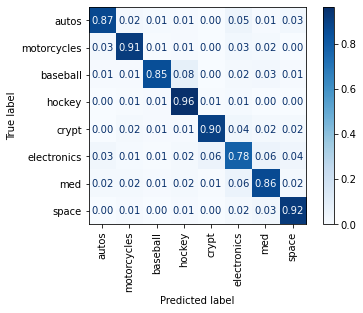

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss="hinge", penalty="l2",
                           alpha=1e-3, random_state=random_seed,
                           max_iter=5, tol=None)
model = Pipeline([
     ("vect", count_vect),
     ("clf", classifier),
])

model.fit(train_data.data, train_data.target)

train_predicted = model.predict(train_data.data)
test_predicted = model.predict(test_data.data)
train_accuracy = np.mean(train_predicted == train_data.target)
test_accuracy = np.mean(test_predicted == test_data.target)

print("Training Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))

print("\nSAMPLE DATA")
sample_predicted = model.predict(sample_sentences)
for i, pred in enumerate(sample_predicted):
    print("Sentence: {}\nPrediction: {}\n".format(
        sample_sentences[i], categories[pred]))

display_labels = [cat.split(".")[-1] for cat in categories]
disp = plot_confusion_matrix(model, test_data.data, test_data.target,
                             display_labels=display_labels,
                             cmap=plt.cm.Blues,
                             normalize="true",
                             xticks_rotation="vertical",
                             values_format=".2f")
plt.show()

IDF weights:

Training Accuracy: 96.68%
Test Accuracy: 87.85%

SAMPLE DATA
Sentence: The Hubble Space Telescope
Prediction: sci.space

Sentence: The red car was speeding down the highway.
Prediction: rec.autos

Sentence: Resistors dissipate heat proportional to the square of the current through them
Prediction: sci.electronics

Sentence: Barry Bonds holds a record for hitting the most home runs
Prediction: rec.sport.baseball

Sentence: The current global pandemic is due to the COVID-19 respiratory disease
Prediction: sci.med



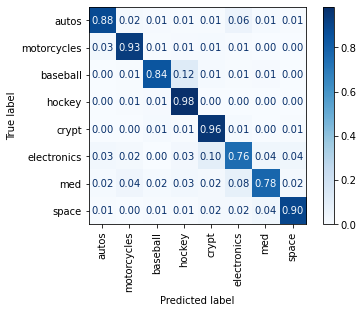

In [143]:
# Now let's add Tf-Idf
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
classifier = SGDClassifier(loss="hinge", penalty="l2",
                           alpha=1e-3, random_state=random_seed,
                           max_iter=5, tol=None)
model = Pipeline([
     ("vect", count_vect),
     ("tfidf", tfidf_transformer),
     ("clf", classifier),
])

model.fit(train_data.data, train_data.target)

print("IDF weights:")
print(model["tfidf"].idf_)
print("")

train_predicted = model.predict(train_data.data)
test_predicted = model.predict(test_data.data)

train_accuracy = np.mean(train_predicted == train_data.target)
test_accuracy = np.mean(test_predicted == test_data.target)

print("Training Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))

print("\nSAMPLE DATA")
sample_predicted = model.predict(sample_sentences)
for i, pred in enumerate(sample_predicted):
    print("Sentence: {}\nPrediction: {}\n".format(
        sample_sentences[i], categories[pred]))

display_labels = [cat.split(".")[-1] for cat in categories]
disp = plot_confusion_matrix(model, test_data.data, test_data.target,
                             display_labels=display_labels,
                             cmap=plt.cm.Blues,
                             normalize="true",
                             xticks_rotation="vertical",
                             values_format=".2f")
plt.show()